In [11]:
import sys
sys.path.append('..')

import numpy as np
from methods.load import load_drb_reconstruction
from methods.moea_generator import Objectives
from methods.objective_functions import mean_drought_duration, mean_drought_severity, mean_drought_magnitude
from methods.constraint_functions import ks_constraint, willcoxon_test, uniform_ks_test

from sglib.methods.nonparametric.kirsch import KirschGenerator


### Load observed data #######################################
# Load DRB flow reconstruction
Q = load_drb_reconstruction()

# Work only with Montague for now
Q = Q[['delMontague']].copy()
Q_monthly = Q.resample('MS').sum()


### Initialize Kirsch generator ##############################
generator = KirschGenerator(Q_monthly)
generator.preprocessing()
generator.fit()

n_years = 20
n_years_with_buffer = n_years + 1

##### Borg Settings #########################################
NFE = 1000
NVARS = int(n_years_with_buffer * 12)  # Each variable represents a month in the n_years period
BOUNDS = [[0.0, int(np.floor(Q_monthly.shape[0]/12))]] * NVARS # limited by Q_monthly size

### Objectives
NOBJS = 4
EPSILONS = [0.1, 1.0, 1.0, 1.0]

### Borg Settings
NCONSTRS = 1
runtime_freq = 250      # output frequency
islands = 4             # 1 = MW, >1 = MM  # Note the total NFE is islands * nfe
borg_seed = 711

### Objective functions ###############################
# Each function will recieve historic flows (Qh) and synthetic flows (Qs) as input

obj_functions = [mean_drought_severity,
                 mean_drought_duration,
                  mean_drought_magnitude]

# The final objective is the Mahalanobis distance from all other objectives and 
# the x* which is opposite the ideal point.
# The objectives are all min, so these should be large positive
x_star = np.array([5, 100, 100])  # Ideal point for the objectives

def manhattan_distance(objs):
    """
    Calculate the Mahalanobis distance from the objectives to the ideal point.
    
    Parameters:
    -----------
    objs : list
        List of objective values.
    x_star : array-like
        Ideal point for the objectives.
    
    Returns:
    --------
    float
        Mahalanobis distance from the objectives to the ideal point.
    """
    objs = np.array(objs)
    scaled_objs = objs / np.array(x_star)
    diff = scaled_objs - np.ones(len(x_star))
    return np.sum(np.abs(diff))

obj_func = Objectives(obj_functions)






In [12]:
# Reformat so that vars is 2d np.array with shape
# (n_years, 12) where each row is a year and each column is a month.
vars = np.random.uniform(0, Q_monthly.shape[0] // 12, size=(NVARS,))
M = np.array(vars).reshape((n_years_with_buffer, 12))


# Make sure M is integer
M = np.floor(M).astype(int)
M = np.clip(M, 0, 79)

constr = uniform_ks_test(M, alpha=0.1)

# Generate a single synthetic trace
Qs_out = generator.generate_single_series(n_years=n_years,
                                            M=M, 
                                            as_array=True).flatten()


# Check if any -np.inf or np.inf values are present in Qs_out
if np.any(np.isinf(Qs_out)) or np.any(np.isnan(Qs_out)):
    raise ValueError("Generated synthetic flow contains infinite or NaN values.")

# check if any 0.0 values are present in Qs_out
if np.any(Qs_out == 0.0):
    raise ValueError("Generated synthetic flow contains zero values, which is not allowed.")


try:
    objectives = obj_func.value(Qh=Q_monthly.values.flatten(), 
                                Qs=Qs_out)

except Exception as e:
    
    print(f"ERROR with:\n\n")  # Debugging output
    print(f"Qs_out shape: {Qs_out.shape}, Qs_out: {Qs_out[:10]}...\n\n")
    print(f"M shape: {M.shape}, M: {M[:5]}...\n\n")


    raise RuntimeError(f"Error evaluating objectives: {e}")


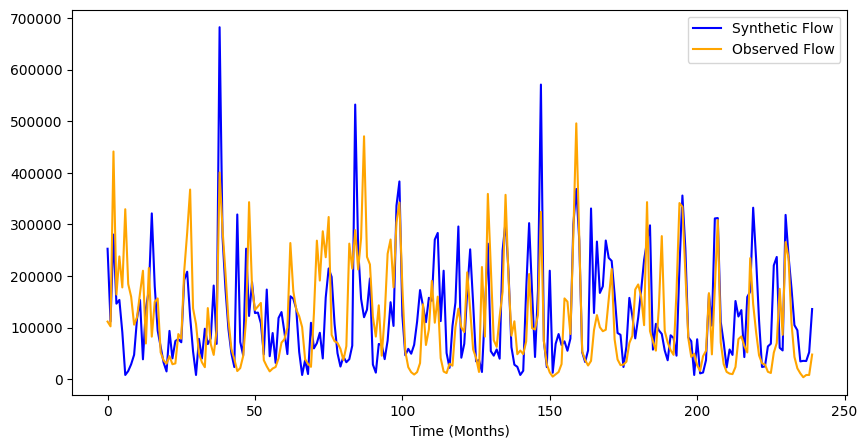

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
xs = np.arange(len(Qs_out))

ax.plot(xs, Qs_out, label='Synthetic Flow', color='blue')
ax.plot(xs, Q_monthly.values.flatten()[:len(Qs_out)], label='Observed Flow', color='orange')
ax.set_xlabel('Time (Months)')  
plt.legend()
plt.show()

In [14]:
import pandas as pd
from sglib.droughts.ssi import SSIDroughtMetrics

# qc = np.concatenate((Q_monthly.values.flatten(), Qs_out), axis=0)

# # Run SSI and drought calculation
# ssi = SSIDroughtMetrics(timescale='M', window=12)
# ssi_values = ssi.calculate_ssi(data=qc)

# droughts = ssi.calculate_drought_metrics(ssi_values)

# droughts = droughts[droughts['start'] >= pd.to_datetime('2024-01-01')]

# droughts['duration'].mean()


mean_drought_duration(Q_monthly.values.flatten(),
                      Qs_out)

np.float64(20.833333333333332)

In [15]:
o = np.array([0,0,0])
manhattan_distance(o)

np.float64(3.0)